In [1]:
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm

import wandb
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [2]:
train_dataset_list = []
test_dataset_list = []

In [12]:
def get_data(df, max_r, max_i, max_p, min_r, min_i, min_p):
    class DOA_dataset(Dataset):
        def __init__(self, df):
            transp = np.transpose(df['NS_data'], (2, 0, 1))
            new = np.zeros((100000, 3, 8, 100))
            for i in range(0, transp.shape[0]):
                for j in range(0, transp.shape[1]):
                    for k in range(0, transp.shape[2]):
                        new[i][0][j][k] = (transp[i][j][k].real - min_r)/(max_r-min_r)
                        new[i][1][j][k] = (transp[i][j][k].imag - min_i)/(max_i-min_i)
                        new[i][2][j][k] = (cmath.phase(transp[i][j][k]) - min_p)/(max_p-min_p)

            self.x = torch.from_numpy(new)
            self.y = torch.from_numpy(np.asarray(df['DOA']))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(df)
    
    # print(df1['DOA'], "Label")
    # print(len(df1['DOA']))
    validation_split = 0.1
    shuffle_dataset = True
    random_seed= 42

    # Creating data indices for training and validation splits:
    dataset_size =  len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]


    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    #dataloader = DataLoader(dataset=dff, batch_size=100, shuffle=True,  num_workers=2)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                             sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=256,
                                                  sampler=valid_sampler)

    train_dataset_list.append(train_loader)
    test_dataset_list.append(validation_loader)


In [3]:
import csv
from sklearn.model_selection import train_test_split

In [4]:
df1  = sio.loadmat("../datasets/doa2_100k/SNR_NS_0_2_100000.mat")
df2  = sio.loadmat("../datasets/doa2_100k/SNR_NS_10_2_100000.mat")
df3  = sio.loadmat("../datasets/doa2_100k/SNR_NS_20_2_100000.mat")
df4  = sio.loadmat("../datasets/doa2_100k/SNR_NS_30_2_100000.mat")
df5  = sio.loadmat("../datasets/doa2_100k/SNR_NS_40_2_100000.mat")

In [5]:
df = [df1, df2, df3, df4, df5]

In [6]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []

In [7]:
def create_dataset(df):
    data = np.transpose(df['NS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

In [8]:
for file in df:
    create_dataset(file)

In [9]:
type(new_test_dataset_list[0])

list

In [26]:
len(test_dataset_list[0][0][0])

100

In [10]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 100))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new

In [11]:
new_train_dataset_list[10].shape

(3, 8, 100)

In [138]:
savez("doa2_train_all.npz", x =train_dataset_list, y= train_dataset_list_label)

In [142]:
a = load("doa2_train_all.npz")

In [168]:
test_dataset_list[0][0].shape

(8, 100)

In [221]:
test_dataset_list[0][0].shape

(3, 8, 100)

In [12]:
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 100))
        for j in range(0, 8):
            for k in range(0, 100):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [13]:
len(new_test_dataset_list[0][0])

3

In [14]:
def get_data(train, test):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    return loader


In [15]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label)

In [34]:
test_dataset_list = []

In [22]:
type(test_dataset_list[0])

torch.utils.data.dataloader.DataLoader

In [33]:
len(test_dataset_list_label[0][0])

2

In [35]:
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx])
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [68]:
type(df1['NS_data'][0])

numpy.ndarray

In [39]:
a.shape

(100000, 8, 100)

In [5]:
# get_data(df1, 0.5758894551931596, 0.6380853569244683, 3.1415901198414034, -0.5932333778145296, -0.607271714192227, -3.1415806765560728)
get_data(df1, 0.831505435520955, 0.6725136140873151, 3.1415912038496554, -0.7381743103431593, -0.7164246971929635, -3.1415922807770897)

In [29]:
# get_data(df2, 0.3317529364916517, 0.2974591210813926, 3.1415889476148022, -0.3139115519334224, -0.308444328952943, -3.1415794980387415)
get_data(df2, 0.4646395177953404, 0.4367299780094817, 3.141586484031158, -0.4281440560152864, -0.4140822527591366, -3.1415925447861683)

In [30]:
# get_data(df3, 0.2655554840881041, 0.247665118111416, 3.141592030578154, -0.24698739374092077, -0.23956457294409056, -3.1415875527493355)
get_data(df3, 0.3578541227152411, 0.37596500122888915, 3.1415913341976944, -0.35028205714253746, -0.3490633963698585, -3.141591973063135)

In [31]:
# get_data(df4, 0.23543194497345557, 0.25995392819084584, 3.141588888231044, -0.24055760389931016, -0.24901315958486156, -3.1415888749544196)
get_data(df4, 0.36433538749617145, 0.35917383519651014, 3.1415884471497524, -0.34959592738096784, -0.3790642081643392, -3.1415887605153516)

In [32]:
# get_data(df5, 0.2273145731425063, 0.22689514780571104, 3.1415880087062704, -0.22586240792168305, -0.2264547166011493, -3.141572217715908)
get_data(df5, 0.3450863705331565, 0.34874138159215795, 3.1415919680614532, -0.32970138712026137, -0.3305079590528899, -3.1415870033923743)

In [6]:
len(train_dataset_list),len(test_dataset_list)

(1, 1)

In [11]:
# print(df1["DOA"].shape)
# print(df1['NS_data'].shape)

In [12]:
# from AttRCNN_UNet import Att_R2U

# preTrained = Att_R2U()


# pre_model = torch.load("./SNR_50000_dropout.pth")

# preTrained.load_state_dict(pre_model, strict=False)

# for prams in preTrained.parameters():
#     prams.requires_grad = False

In [13]:


# from torchsummary import summary
# summary(autoencoder.cuda(), (3, 8, 100))

In [14]:
# # Loading weights
# pre_model = torch.load("./triplet_loss.pth")
# autoencoder.load_state_dict(pre_model, strict=False)

# for prams in autoencoder.parameters():
#     prams.requires_grad = False

In [15]:
# class DOA(nn.Module):
#     def __init__(self,img_ch=3,output_ch=3,t=2):
#         super(DOA, self).__init__()
#         self.embedding = autoencoder
#         self.linear1 = nn.Linear(181, 100)
#         self.linear2 = nn.Linear(100, 181)
#         self.flat = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=1)

#     def forward(self, image):
#         x = self.embedding(image)
# #         print(x.size())
#         x = self.linear1(x)
#         x = self.linear2(x)
# #         print(x.size())
#         x = x.reshape(image.size()[0],1,1,181)
#         x = self.flat(x)
# #         print("classificationLayer =>",x.size())
# #         out = torch.nn.functional.log_softmax(x, dim=1)
# #         print(x.size())
#         return x
# if __name__ == "__main__":
#     image = torch.rand(1, 3, 8, 100)
#     en = DOA()
#     en(image)


## Triplet Loss

In [16]:
# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [17]:
# def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, labels) in enumerate(train_loader):
#         data, labels = Variable(data.cuda()), Variable(labels.cuda())
#         optimizer.zero_grad()
#         embeddings = model(data.float())
#         indices_tuple = mining_func(embeddings, labels.reshape(-1))
#         loss = loss_func(embeddings, labels, indices_tuple)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 1400 == 0:
#             print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

# ### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester()
#     return tester.get_all_embeddings(dataset, model)

# def test(testloader, model):
#     model.eval()
#     validation_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for features, labels in testloader:
#             features, labels = Variable(features.cuda()), Variable(labels.cuda())
#             enn = autoencoder(features.float())
#             auto_outputs = torch.transpose(enn, 2, 3)
#             auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
#             loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

#             _, pred = torch.max(auto_outputs, 1)
#             total+= labels.reshape(-1).size(0)
#             correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
#             validation_loss += loss.item()
# #             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
#     print(val_data*10, "dB SNR is validated")
# #     vl1[val_data].append((100*(correct/total)))
#     print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
# print("\n")  
    
    
# device = torch.device("cuda")

# model = autoencoder.cuda()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ### pytorch-metric-learning stuff ###
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.NTXentLoss(temperature=0.07) #losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
# accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)


In [18]:
# for epoch in range(0, 100):
#     for data in range(0, len(train_dataset_list)):
#         print("Training has started for ", str(data*10), "dB SNR" )
#         train(model, loss_func, mining_func, device, train_dataset_list[data], optimizer, epoch+1)
# #     for val_data in range(0, len(test_dataset_list)):
# #         print("Validation has started for ", str(val_data*10), "dB SNR" )
# #         test(train_dataset_list[val_data], test_dataset_list[val_data], model, accuracy_calculator)

In [19]:
# import torch.optim.lr_scheduler.StepLR
# exp_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma = 0.1)

In [20]:
# import wandb

# wandb.login()

# torch.cuda.empty_cache()

# wandb.init(project="UNET_MVCNN_CNN_v1_Full_train_parVal")

In [36]:
ep = []
tr = []

from resnet34 import ResNet34, ResNet18, ResNet101
from resnext import Inceptionv4
res_model = ResNet34()
model = res_model

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = model.cuda()
	optimizer = optim.Adam(classification_model.parameters(), lr=1e-3, weight_decay=1e-5)
	criterion = criterion.cuda()


GeForce GTX 1080 Ti


In [37]:
vl1 = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[]
}

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    for i in range(50):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        epoch_loss = 0.0
        training_mae = 0.0
#         for data in range(0, len(train_dataset_list)):
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 2))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#                 exp_scheduler.step()
            training_loss += losss.item()
            _, pred = torch.max(auto_outputs, 1)
            ttotal+= labels.reshape(-1).size(0)
            tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            epoch_loss += auto_outputs.shape[0] * losss.item()
#             training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (i + 1, j + 1, training_loss / 2000))
                training_loss = 0.0
#         wandb.log({"Trainig Acc":(100*(tcorrect/ttotal)), "Traningloss":(training_loss/len(train_dataset_list[data]))})
        tr.append((100*(tcorrect/ttotal)))
        print("Epoch {}  \nTraningloss: {}".format(i+1, training_loss/len(doa2_train_loader)), " ---- Trainig Acc: {}".format( 100*(tcorrect/ttotal)))
            
        classification_model.eval()
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_mae = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 2))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    total+= labels.reshape(-1).size(0)
                    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
            print(val_data*10, "dB SNR is validated")
            vl1[val_data].append((100*(correct/total)))
            print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
        print("\n")  
        ep.append(i)
#     wandb.finish()
		

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch 1  
Traningloss: 2.373786176776886  ---- Trainig Acc: 25.033125000000002
0 dB SNR is validated
Validationloss: 2.1398761737080045  ---- Validation Acc: 28.665000000000003
10 dB SNR is validated
Validationloss: 1.4420758424856412  ---- Validation Acc: 42.7875
20 dB SNR is validated
Validationloss: 1.282006517005043  ---- Validation Acc: 46.94
30 dB SNR is validated
Validationloss: 1.270496653291745  ---- Validation Acc: 47.362500000000004
40 dB SNR is validated
Validationloss: 1.2585377818860186  ---- Validation Acc: 47.417500000000004


Epoch 2  
Traningloss: 1.1593992609596253  ---- Trainig Acc: 55.684
0 dB SNR is validated
Validationloss: 1.8304614575145344  ---- Validation Acc: 36.8925
10 dB SNR is validated
Validationloss: 0.947648673011853  ---- Validation Acc: 62.395
20 dB SNR is validated
Validationloss: 0.691305374946838  ---- Validation Acc: 71.665
30 dB SNR is validated
Validationloss: 0.662311279545196  ---- Validation Acc: 72.38
40 dB SNR is va

In [36]:
def train():
    print("Training Starts !!!!!!!")
    for i in range(50):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        epoch_loss = 0.0
        training_mae = 0.0
        for data in range(0, len(train_dataset_list)):
            classification_model.train()
            for j,(features, labels) in enumerate(train_dataset_list[data], 0):
                features, labels = Variable(features.cuda()), Variable(labels.cuda())
                optimizer.zero_grad()
                enn = classification_model(features.float())
                auto_outputs = torch.transpose(enn, 2, 3)
                auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 2))
                losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
                losss.backward()
                optimizer.step()
#                 exp_scheduler.step()
                training_loss += losss.item()
                _, pred = torch.max(auto_outputs, 1)
                ttotal+= labels.reshape(-1).size(0)
                tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                epoch_loss += auto_outputs.shape[0] * losss.item()
                training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (i + 1, j + 1, training_loss / 2000))
                    training_loss = 0.0
#         wandb.log({"Trainig Acc":(100*(tcorrect/ttotal)), "Traningloss":(training_loss/len(train_dataset_list[data]))})
        tr.append((100*(tcorrect/ttotal)))
        print("Epoch {}  \nTraningloss: {}".format(i+1, training_loss/len(train_dataset_list[data])), " ---- Trainig Acc: {}".format( 100*(tcorrect/ttotal)), " ---- Trainig MAE: {}".format( training_mae/len(train_dataset_list[data])))
            
        classification_model.eval()
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_mae = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 2))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    total+= labels.reshape(-1).size(0)
                    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
            print(val_data*10, "dB SNR is validated")
            vl1[val_data].append((100*(correct/total)))
            print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
        print("\n")  
        ep.append(i)
#     wandb.finish()
		

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch 1  
Traningloss: 11.172455108538534  ---- Trainig Acc: 30.539333333333335  ---- Trainig MAE: 6861.07960199005
0 dB SNR is validated
Validationloss: 9.63906729221344  ---- Validation Acc: 2.8000000000000003
10 dB SNR is validated
Validationloss: 2.5954620599746705  ---- Validation Acc: 30.964999999999996
20 dB SNR is validated
Validationloss: 2.3270887970924377  ---- Validation Acc: 42.83
30 dB SNR is validated
Validationloss: 3.5884485721588133  ---- Validation Acc: 33.18
40 dB SNR is validated
Validationloss: 1.3054748833179475  ---- Validation Acc: 51.66


Epoch 2  
Traningloss: 5.574595889027608  ---- Trainig Acc: 59.10411111111111  ---- Trainig MAE: 2529.500355366027
0 dB SNR is validated
Validationloss: 14.622581911087035  ---- Validation Acc: 4.52
10 dB SNR is validated
Validationloss: 2.1429899990558625  ---- Validation Acc: 50.68
20 dB SNR is validated
Validationloss: 1.1617761239409448  ---- Validation Acc: 70.91
30 dB SNR is validated
Validationl

KeyboardInterrupt: 

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    for i in range(100):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        epoch_loss = 0.0
        for data in range(0, len(train_dataset_list)):
            classification_model.train()
            for j,(features, labels) in enumerate(train_dataset_list[data], 0):
                features, labels = Variable(features.cuda()), Variable(labels.cuda())
                optimizer.zero_grad()
                enn = classification_model(features.float())
                auto_outputs = torch.transpose(enn, 2, 3)
                auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
                losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
                losss.backward()
                optimizer.step()
#                 exp_scheduler.step()
                training_loss += losss.item()
                _, pred = torch.max(auto_outputs, 1)
                ttotal+= labels.reshape(-1).size(0)
                tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                epoch_loss += auto_outputs.shape[0] * losss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (i + 1, j + 1, training_loss / 2000))
                    training_loss = 0.0
#         wandb.log({"Trainig Acc":(100*(tcorrect/ttotal)), "Traningloss":(training_loss/len(train_dataset_list[data]))})
        tr.append((100*(tcorrect/ttotal)))
        print("Epoch {}  \nTraningloss: {}".format(i+1, training_loss/len(train_dataset_list[data])), " ---- Trainig Acc: {}".format( 100*(tcorrect/ttotal)))

            
        classification_model.eval()
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    total+= labels.reshape(-1).size(0)
                    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
            print(val_data*10, "dB SNR is validated")
            vl1[val_data].append((100*(correct/total)))
            print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
        print("\n")  
        ep.append(i)
#     wandb.finish()
		

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch 1  
Traningloss: 7.438546144587265  ---- Trainig Acc: 49.55844444444445
0 dB SNR is validated
Validationloss: 0.4146145835518837  ---- Validation Acc: 86.11999999999999
10 dB SNR is validated
Validationloss: 0.43051193878054617  ---- Validation Acc: 84.93
20 dB SNR is validated
Validationloss: 0.4282748721539974  ---- Validation Acc: 84.92
30 dB SNR is validated
Validationloss: 0.4399769984185696  ---- Validation Acc: 84.77
40 dB SNR is validated
Validationloss: 0.4344377838075161  ---- Validation Acc: 85.5


Epoch 2  
Traningloss: 2.0570272410489086  ---- Trainig Acc: 84.71088888888889
0 dB SNR is validated
Validationloss: 0.4637110263109207  ---- Validation Acc: 81.57
10 dB SNR is validated
Validationloss: 0.4812937192618847  ---- Validation Acc: 80.85
20 dB SNR is validated
Validationloss: 0.4740179628133774  ---- Validation Acc: 81.08999999999999
30 dB SNR is validated
Validationloss: 0.4842801295220852  ---- Validation Acc: 81.08999999999999
40 dB SNR

In [24]:
#ResNet34
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

(62.22, 91.14, 97.46000000000001, 98.9, 99.64)

In [1]:
#ResNet34
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

NameError: name 'vl1' is not defined

In [22]:
#ResNet 101
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

(63.72, 91.5, 97.96000000000001, 99.0, 99.58)

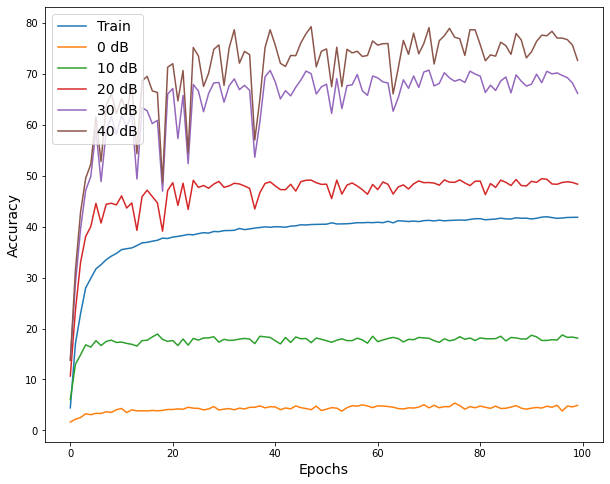

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(ep, tr, label='Train')
plt.plot(ep, vl1[0], label='0 dB')
plt.plot(ep, vl1[1], label='10 dB')
plt.plot(ep, vl1[2], label='20 dB')
plt.plot(ep, vl1[3], label='30 dB')
plt.plot(ep, vl1[4], label='40 dB')
# plt.plot(ep, vl1[5], label='50 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("8_resnet34")
plt.show()

<Figure size 432x288 with 0 Axes>

In [70]:
print(model)

DOA(
  (embedding): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=